In [ ]:
# Actualizamos paquetes críticos y listamos todos los instalados en la VM

In [ ]:
%%bash 
pip install sklearn --upgrade
pip install --upgrade tensorflow
pip freeze

In [ ]:
"""
Ejemplo 1: llamada a la API de BQ 
Extraído de los notebooks de muestra de Datalab 
"""

In [1]:
import google.datalab.bigquery as bq

# Hacemos una query para obtenerlos nacimientos de varones cada año
total_births = bq.Query('SELECT CAST(source_year AS string) AS year, COUNT(is_male) AS birth_count FROM `publicdata.samples.natality` GROUP BY year ORDER BY year DESC LIMIT 15')
df = total_births.execute(output_options=bq.QueryOutput.dataframe()).result()

# Vemos las 10 primeras filas del dataframe
df.head(10)


,year,birth_count
0,2008,4255156
1,2007,4324008
2,2006,4273225
3,2005,4145619
4,2004,4118907
5,2003,4096092
6,2002,4027376
7,2001,4031531
8,2000,4063823
9,1999,3963465


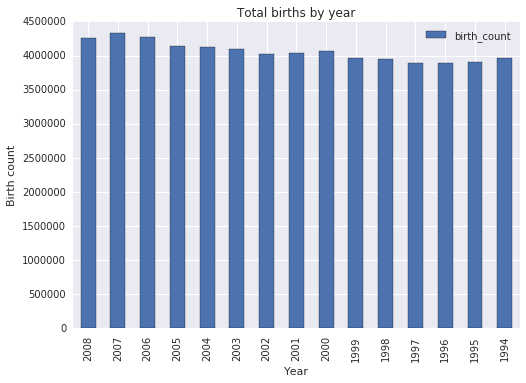

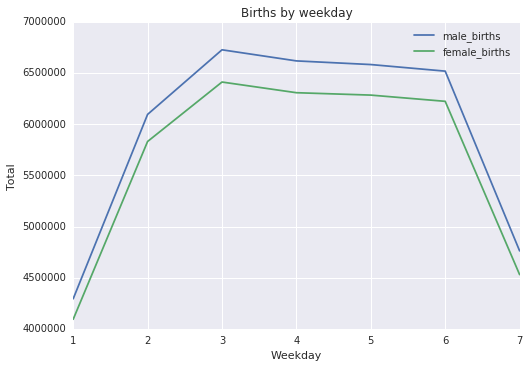

In [2]:

# Ploteamos la query
ax = df.plot(kind='bar',x='year',title='Total births by year')
ax.set_xlabel('Year')
ax.set_ylabel('Birth count')

# Hacemos una query para obtenerlos nacimientos de niños cada día de la semana
births_by_weekday = bq.Query('SELECT CAST(wday AS string) AS weekday, SUM(CASE WHEN is_male THEN 1 ELSE 0 END) AS male_births, SUM(CASE WHEN is_male THEN 0 ELSE 1 END) AS female_births FROM `publicdata.samples.natality` WHERE wday IS NOT NULL GROUP BY weekday ORDER BY weekday ASC')
df2 = births_by_weekday.execute(output_options=bq.QueryOutput.dataframe()).result()

# Ploteamos la query
df2 = births_by_weekday.execute(output_options=bq.QueryOutput.dataframe()).result()
ax = df2.plot(kind='line',x='weekday',title='Births by weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Total')

In [ ]:
"""
Ejemplo 2: llamada llamada 'mágica' a BQ
Usamos la tabla de BQ de ejemplo con los viajes en taxi en Chicago desde 2013 (105 millones de filas - 36GB)
Intentaremos predecir el precio del viaje en taxi en función de las coordenadas donde se recoge y se deja al cliente, la duración y la distancia del viaje
"""

In [3]:
from __future__ import division

import google.datalab.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%%bq query -n taxi_queries
SELECT trip_seconds, trip_miles, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_miles IS NOT NULL AND
      trip_seconds IS NOT NULL AND
      pickup_latitude IS NOT NULL AND 
      pickup_longitude IS NOT NULL AND
      dropoff_latitude IS NOT NULL AND
      dropoff_longitude IS NOT NULL AND  
      fare IS NOT NULL
LIMIT 300000



In [5]:
# Ejecutamos la query
df = taxi_queries.execute(output_options=bq.QueryOutput.dataframe()).result()

In [6]:
df.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,600,0.1,41.920452,-87.679955,41.936159,-87.661265,8.25
1,360,0.8,41.920452,-87.679955,41.906026,-87.675312,5.65
2,600,2.1,41.920452,-87.679955,41.929078,-87.646293,7.65
3,360,4.5,41.920452,-87.679955,41.871016,-87.631407,11.25
4,0,0.0,41.849247,-87.624135,41.849247,-87.624135,0.00


In [7]:
# Normalización de columnas (normalizamos todo el dataset, por lo que no tenemos que guardar la media ni la desviación)

cols_to_norm = ['pickup_latitude','pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

df.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,600,0.1,0.504365,-0.402577,0.875332,-0.119757,8.25
1,360,0.8,0.504365,-0.402577,0.088528,-0.363263,5.65
2,600,2.1,0.504365,-0.402577,0.690430,0.139791,7.65
3,360,4.5,0.504365,-0.402577,-0.825619,0.397869,11.25
4,0,0.0,-1.446733,0.482258,-1.394032,0.523922,0.00


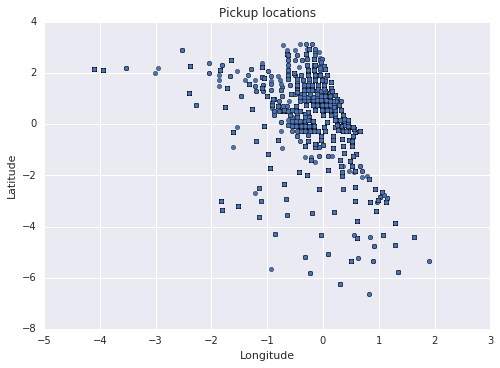

In [8]:
ax = df.plot(kind='scatter',x='pickup_longitude', y='pickup_latitude', title='Pickup locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

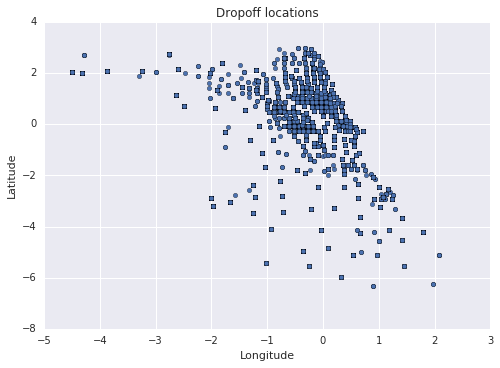

In [9]:
ax = df.plot(kind='scatter',x='dropoff_longitude', y='dropoff_latitude', title='Dropoff locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

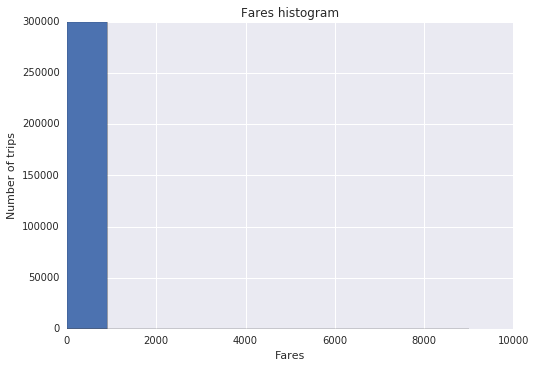

In [12]:
ax = df['fare'].hist()
ax.set_xlabel('Fares')
ax.set_ylabel('Number of trips')
ax.set_title('Fares histogram')

In [13]:
# Veamos tras aplicar algoritmos de reducción de dimensionalidad si los viajes con tarifas más comunes son "diferentes" del resto (es decir, si no tenemos que hacer feature engineering)

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

df_aux = df.sample(500)

# Consideramos tarifas "normales" entre $4.8 y $7.5
df_aux['normal_fare'] = df_aux['fare'].apply(lambda x: 1 if x >= 4.8 and x <= 7.5  else 0)
df_aux.drop('fare', axis=1, inplace=True)

# Nos quedamos con la columna de etiquetas
y = df_aux.ix[:,-1].values

df_aux.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,normal_fare
195825,480,0.09,-0.274087,0.359746,-0.460814,0.578398,1
181186,360,1.30,0.565601,0.080362,1.085983,-0.028448,1
75424,300,1.40,-0.576806,0.345756,-0.061878,0.385687,1
104526,0,0.00,-0.304779,0.565749,-0.305850,0.615229,0
180773,960,0.00,-0.063227,-0.164788,0.933617,0.273599,0


In [14]:
df_aux['normal_fare'].describe()

count    500.000000
mean       0.398000
std        0.489976
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: normal_fare, dtype: float64

In [15]:
#Construimos un gráfico con los puntos obtenidos al aplicar tsne o PCA
def plot_data_2d(X, y, x_lims = None, y_lims = None):
  color_map = {0:'red', 1:'blue'}
  plt.figure()
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = X[y==cl,0], 
                y = X[y==cl,1], 
                c = color_map[idx], 
                label = cl)
  plt.xlabel('X in t-SNE')
  plt.ylabel('Y in t-SNE')
  plt.legend(loc='upper left')
  plt.title('t-SNE visualization of Chicago taxi trips')
  if x_lims is not None and y_lims is not None:
    plt.xlim(x_lims)
    plt.ylim(y_lims)
  plt.show()
  

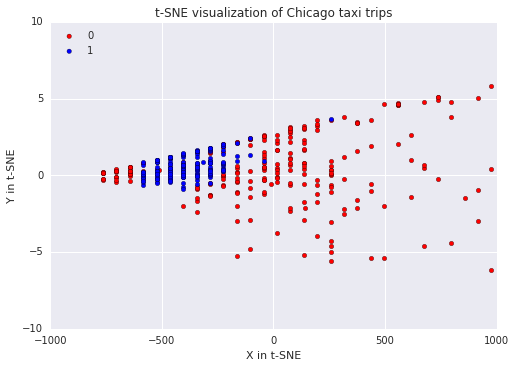

In [16]:
# Usamos PCA en este caso
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(df_aux)
X = pca.transform(df_aux)

x_lims = (X[:,0].mean()-1000,X[:,0].mean()+1000)
y_lims = (X[:,1].mean()-10,X[:,1].mean()+10)

plot_data_2d(X, y, x_lims, y_lims)

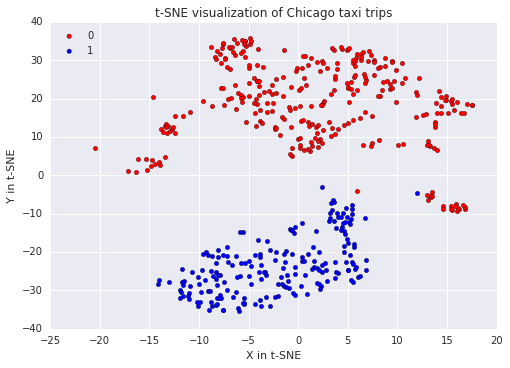

In [17]:
# Creamos una visualización en 2d con el algoritmo t-SNE para ver la diferencia entre viajes con tarifas "más comunes" y el resto
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


# Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df_std = standard_scaler.fit_transform(df_aux)

# Compute t-SNE algorithm
tsne = TSNE(n_components=2, random_state=0)
tsne_2d = tsne.fit_transform(df_std)

#Construimos un gráfico con los puntos obtenidos al aplicar tsne
plot_data_2d(tsne_2d, y)

In [18]:
import numpy as np
import sklearn.model_selection as ms

TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

dataset = df.as_matrix()

X_train, X_test, Y_train, Y_test = ms.train_test_split(dataset[:,:-1], dataset[:,-1], test_size=TEST_SIZE)

X_train, X_val, Y_train, Y_val = ms.train_test_split(X_train, Y_train, test_size=VAL_SIZE/TRAIN_SIZE)

In [19]:
import numpy as np
#import tensorflow
#import tensorflow as tf
import sys
import tensorflow.contrib.keras as keras

In [20]:
#from tensorflow.contrib.keras import *
from tensorflow.contrib.keras.python.keras.regularizers import l1,l2
from tensorflow.contrib.keras.python.keras.models import Sequential, load_model
from tensorflow.contrib.keras.python.keras.layers import Dense, Dropout, Activation
from tensorflow.contrib.keras.python.keras.constraints import max_norm
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adam
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
import os

# Disable info warnings from TF
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'




In [27]:

# Volvemos a limitar el resultado de la query
LIMIT = 10000

# Limitamos los ejemplos de entrenamiento a viajes de menos de 20$

mask_train = Y_train < 20
mask_val = Y_val < 20
mask_test = Y_test < 20


X_train = X_train[mask_train]
Y_train = Y_train[mask_train]
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]


# Hyperparameters
batch_size = 500
epochs = 200
dropout_rate = 0.5

TRAIN_LIMIT = int(LIMIT*TRAIN_SIZE)
VAL_LIMIT = int(LIMIT*VAL_SIZE)
TEST_LIMIT = int(LIMIT*TEST_SIZE)

x_train = X_train[:TRAIN_LIMIT]
y_train = Y_train[:TRAIN_LIMIT]
x_val = X_val[:VAL_LIMIT]
y_val = Y_val[:VAL_LIMIT]
x_test = X_test[:TEST_LIMIT]
y_test = Y_test[:TEST_LIMIT]

# Tenemos 6 neuronas de entrada
input_dim = dataset.shape[1] - 1

model = Sequential()
model.add(Dense(2,input_shape=(input_dim,), kernel_initializer='he_normal'))
#model.add(Dense(3,input_shape=(input_dim,)))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=[keras.metrics.mean_absolute_error, keras.metrics.mean_absolute_percentage_error])

# Entrenamos el modelo (con verbose 0 apagamos el log y con 1 se muestra con barra de progreso)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_val, y_val))


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss (mse):', score[0])
print('Test mae:', score[1])
print('Test mape:', score[2])

y_pred = model.predict_proba(x_test, verbose = 0)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 14        
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 8         
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 25.0
Trainable params: 21.0
Non-trainable params: 4.0
_________________________________________________________________
('Test loss (mse):', 13.998922546386719)
('Test mae:', 2.5719992065429689)
('Test mape:', 6698711.4230972286)


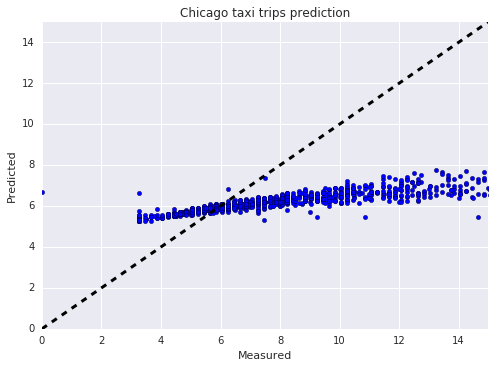

In [28]:
import matplotlib.pyplot as plt

PLOT_LIM = 15
# Plot para ver como se desvían nuestras prediciones
fig, ax = plt.subplots()
ax.scatter(y_test[:LIMIT], y_pred[:LIMIT] )
ax.plot([0, PLOT_LIM], [0, PLOT_LIM], 'k--', lw=3)
ax.set_xlim([0, PLOT_LIM])
ax.set_ylim([0, PLOT_LIM])
ax.set_title('Chicago taxi trips prediction')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [29]:
y_pred = model.predict_proba(x_test[49:50], verbose = 0)

In [30]:
y_pred

array([[ 5.89385748]], dtype=float32)

In [31]:
y_test[49:50]

array([ 5.25])

In [33]:
abs(y_pred - y_test[49:50])

array([[ 0.64385748]])